In [1]:
import cv2
import numpy as np
import os
from glob import glob
from os.path import join
import tarfile
import urllib
from matplotlib import pyplot as plt
import tensorflow as tf

In [2]:
import os
img_path = os.getenv('HOME')+'/aiffel/human_segmentation/images/my_image.png'  # 본인이 선택한 이미지의 경로에 맞게 바꿔 주세요.
img_orig = cv2.imread(img_path)
print (img_orig.shape)

(450, 800, 3)


In [3]:
class DeepLabModel(object):
    INPUT_TENSOR_NAME = 'ImageTensor:0'
    OUTPUT_TENSOR_NAME = 'SemanticPredictions:0'
    INPUT_SIZE = 513
    FROZEN_GRAPH_NAME = 'frozen_inference_graph'

    # __init__()에서 모델 구조를 직접 구현하는 대신, tar file에서 읽어들인 그래프구조 graph_def를 
    # tf.compat.v1.import_graph_def를 통해 불러들여 활용하게 됩니다. 
    def __init__(self, tarball_path):
        self.graph = tf.Graph()
        graph_def = None
        tar_file = tarfile.open(tarball_path)
        for tar_info in tar_file.getmembers():
            if self.FROZEN_GRAPH_NAME in os.path.basename(tar_info.name):
                file_handle = tar_file.extractfile(tar_info)
                graph_def = tf.compat.v1.GraphDef.FromString(file_handle.read())
                break
        tar_file.close()

        with self.graph.as_default():
            tf.compat.v1.import_graph_def(graph_def, name='')

        self.sess = tf.compat.v1.Session(graph=self.graph)

    # 이미지를 전처리하여 Tensorflow 입력으로 사용 가능한 shape의 Numpy Array로 변환합니다.
    def preprocess(self, img_orig):
        height, width = img_orig.shape[:2]
        resize_ratio = 1.0 * self.INPUT_SIZE / max(width, height)
        target_size = (int(resize_ratio * width), int(resize_ratio * height))
        resized_image = cv2.resize(img_orig, target_size)
        resized_rgb = cv2.cvtColor(resized_image, cv2.COLOR_BGR2RGB)
        img_input = resized_rgb
        return img_input
        
    def run(self, image):
        img_input = self.preprocess(image)

        # Tensorflow V1에서는 model(input) 방식이 아니라 sess.run(feed_dict={input...}) 방식을 활용합니다.
        batch_seg_map = self.sess.run(
            self.OUTPUT_TENSOR_NAME,
            feed_dict={self.INPUT_TENSOR_NAME: [img_input]})

        seg_map = batch_seg_map[0]
        return cv2.cvtColor(img_input, cv2.COLOR_RGB2BGR), seg_map

In [4]:
# define model and download & load pretrained weight
_DOWNLOAD_URL_PREFIX = 'http://download.tensorflow.org/models/'

model_dir = '~/aiffel/human_segmentation/models'
tf.io.gfile.makedirs(model_dir)

print ('temp directory:', model_dir)

download_path = os.path.join(model_dir, 'deeplab_model.tar.gz')
if not os.path.exists(download_path):
    urllib.request.urlretrieve(_DOWNLOAD_URL_PREFIX + 'deeplabv3_mnv2_pascal_train_aug_2018_01_29.tar.gz',
                   download_path)

MODEL = DeepLabModel(download_path)
print('model loaded successfully!')

temp directory: ~/aiffel/human_segmentation/models
model loaded successfully!


In [5]:
img_resized, seg_map = MODEL.run(img_orig)
print (img_orig.shape, img_resized.shape, seg_map.max())

(450, 800, 3) (288, 513, 3) 20


In [6]:
LABEL_NAMES = [
    'background', 'aeroplane', 'bicycle', 'bird', 'boat', 'bottle', 'bus',
    'car', 'cat', 'chair', 'cow', 'diningtable', 'dog', 'horse', 'motorbike',
    'person', 'pottedplant', 'sheep', 'sofa', 'train', 'tv'
]
len(LABEL_NAMES)

21

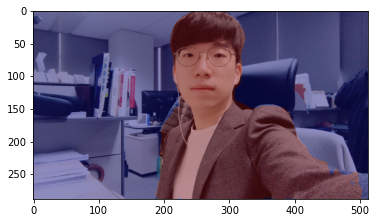

In [7]:
img_show = img_resized.copy()
seg_map = np.where(seg_map == 15, 15, 0) # 예측 중 사람만 추출
img_mask = seg_map * (255/seg_map.max()) # 255 normalization
img_mask = img_mask.astype(np.uint8)
color_mask = cv2.applyColorMap(img_mask, cv2.COLORMAP_JET)
img_show = cv2.addWeighted(img_show, 0.6, color_mask, 0.35, 0.0)

plt.imshow(cv2.cvtColor(img_show, cv2.COLOR_BGR2RGB))
plt.show()

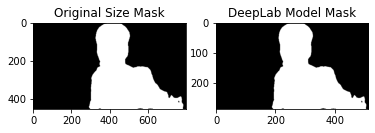

In [8]:
img_mask_up = cv2.resize(img_mask, img_orig.shape[:2][::-1], interpolation=cv2.INTER_LINEAR)
_, img_mask_up = cv2.threshold(img_mask_up, 128, 255, cv2.THRESH_BINARY)

ax = plt.subplot(1,2,1)
plt.imshow(img_mask_up, cmap=plt.cm.binary_r)
ax.set_title('Original Size Mask')

ax = plt.subplot(1,2,2)
plt.imshow(img_mask, cmap=plt.cm.binary_r)
ax.set_title('DeepLab Model Mask')

plt.show()

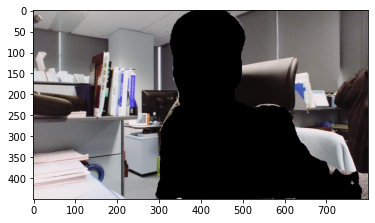

In [9]:
img_mask_color = cv2.cvtColor(img_mask_up, cv2.COLOR_GRAY2BGR)
img_bg_mask = cv2.bitwise_not(img_mask_color)
img_bg = cv2.bitwise_and(img_orig, img_bg_mask)
plt.imshow(img_bg)
plt.show()

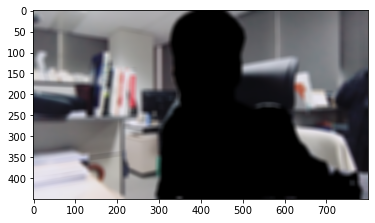

In [10]:
img_bg_blur = cv2.blur(img_bg, (13,13))
plt.imshow(cv2.cvtColor(img_bg_blur, cv2.COLOR_BGR2RGB))
plt.show()

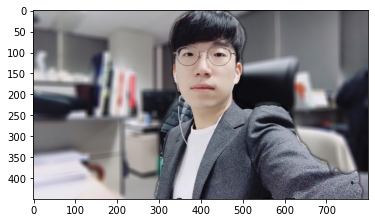

In [11]:
img_concat = np.where(img_mask_color==255, img_orig, img_bg_blur)
plt.imshow(cv2.cvtColor(img_concat, cv2.COLOR_BGR2RGB))
plt.show()

In [12]:
cat_path = os.getenv('HOME')+'/aiffel/human_segmentation/images/cat.jpeg'  # 본인이 선택한 이미지의 경로에 맞게 바꿔 주세요.
img_cat = cv2.imread(cat_path)

In [17]:
img_resized, seg_map = MODEL.run(img_cat)
print (img_cat.shape, img_resized.shape, seg_map.max())

(244, 206, 3) (513, 433, 3) 8


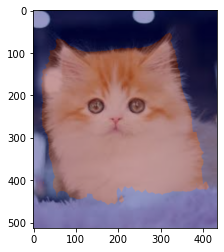

In [18]:
img_show = img_resized.copy()
seg_map = np.where(seg_map == 8, 8, 0) # 예측 중 사람만 추출
img_mask = seg_map * (255/seg_map.max()) # 255 normalization
img_mask = img_mask.astype(np.uint8)
color_mask = cv2.applyColorMap(img_mask, cv2.COLORMAP_JET)
img_show = cv2.addWeighted(img_show, 0.6, color_mask, 0.35, 0.0)

plt.imshow(cv2.cvtColor(img_show, cv2.COLOR_BGR2RGB))
plt.show()

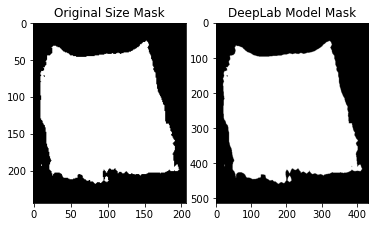

In [21]:
img_mask_up = cv2.resize(img_mask, img_cat.shape[:2][::-1], interpolation=cv2.INTER_LINEAR)
_, img_mask_up = cv2.threshold(img_mask_up, 128, 255, cv2.THRESH_BINARY)

ax = plt.subplot(1,2,1)
plt.imshow(img_mask_up, cmap=plt.cm.binary_r)
ax.set_title('Original Size Mask')

ax = plt.subplot(1,2,2)
plt.imshow(img_mask, cmap=plt.cm.binary_r)
ax.set_title('DeepLab Model Mask')

plt.show()

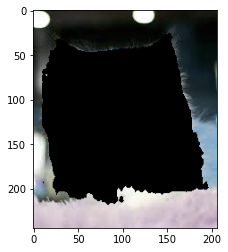

In [22]:
img_mask_color = cv2.cvtColor(img_mask_up, cv2.COLOR_GRAY2BGR)
img_bg_mask = cv2.bitwise_not(img_mask_color)
img_bg = cv2.bitwise_and(img_cat, img_bg_mask)
plt.imshow(img_bg)
plt.show()

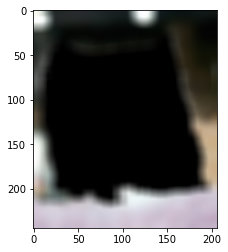

In [23]:
img_bg_blur = cv2.blur(img_bg, (13,13))
plt.imshow(cv2.cvtColor(img_bg_blur, cv2.COLOR_BGR2RGB))
plt.show()

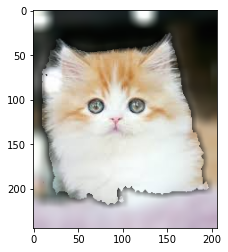

In [25]:
img_concat = np.where(img_mask_color==255, img_cat, img_bg_blur)
plt.imshow(cv2.cvtColor(img_concat, cv2.COLOR_BGR2RGB))
plt.show()

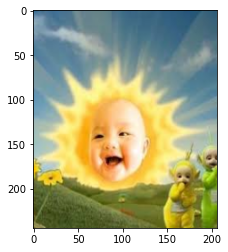

In [32]:
bg_path = os.getenv('HOME')+'/aiffel/human_segmentation/images/gogoma.jpeg'  # 본인이 선택한 이미지의 경로에 맞게 바꿔 주세요.
bg = cv2.resize(cv2.imread(bg_path),(img_cat.shape[1],img_cat.shape[0]))
plt.imshow(cv2.cvtColor(bg,cv2.COLOR_BGR2RGB))
plt.show()

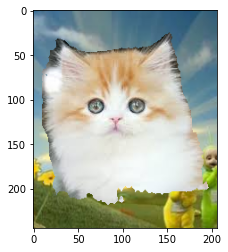

In [33]:
img_concat = np.where(img_mask_color==255, img_cat, bg)
plt.imshow(cv2.cvtColor(img_concat, cv2.COLOR_BGR2RGB))
plt.show()

##### 스무딩 연산을 하는 경우 경계면이 부자연스럽다는 문제점이 존재한다. 이는 다른 배경에 합성시에도 발생하는 문제이며 다른 배경에 합성시에는 위와 같이 기존의 이미지에 엄연히 전경과 배경이 존재하는데 이에대해 전경과 배경을 분리 한 후에 합성을 하는게 맞는것같다. 하지만 데이터에 산에 대한 분류가 없어서 새로 학습이 필요하다.

##### 세그맨테이션으로는 100%의 정확도가 힘들기 때문에 depth를 활용한 방식이 있다고 노드에 추천이 되어 있다. 반대로 depth를 이용해 segmentation을 보완하기에는 depth도 정확도가 100%가 아니고 두가지를 상호 보완한다면 차 유리와 같은 투명한 물체에 대해서는 어떻게 처리를 할지 대안이 떠오르지 않는다.이에 대해서는 정확한 솔루션이 떠오르지 않고 노드에서 추천된 방식에 대해 다음의 반문과 간단한 가정상에서 시도할만한 방법 정도만 떠오른다.
- 1. Depth camera 혹은 IR 카메라를 쓰는 경우: 모든 소비자가 Depth camera를 쓸 정도로 보급이 되어 있지 않다. 따라서 적절하지 않다고 생각한다.
- 2. struct2Depth와 같은 unsupervised Depth estimation : kitti, cityscape와 같은 데이터를 제작해야 한다. 이 부분에는 카메라 파라미터 추출, 영상정렬화가 된 이미지가 대응되는 쌍으로 존재해야한다. 데이터가 완성이 되었다고 하더라도 unsupervised 특성상 높은 정확도를 기대하기 어렵다. 다만 segmentation을 이용해 정확도를 높이는 방법이 구글에서 제안되기는 하였었다.

##### 만약 segmentation은 부정확하지만 depth는 100%를 보장할 경우 segment 영역내에 임의의 임계값 이상으로 주변 픽셀과 depth값이 차이나는 경우 그 영역내에서 segment를 다시 수행하는 정도가 떠오른다.